In [2]:
# ======================================
# 0. 기본 라이브러리
# ======================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from bs4 import BeautifulSoup
import requests
import openpyxl
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
import time
from selenium.webdriver.common.by  import By
from selenium.webdriver.common.keys import Keys

from pathlib import Path
import shutil
from datetime import datetime

import matplotlib.font_manager as fm
from matplotlib import rcParams


# ======================================
# 1. 스타일 먼저 (중요: 폰트보다 먼저)
# ======================================
plt.style.use('_mpl-gallery-nogrid')   # matplotlib 스타일
sns.set_theme(style="white")           # seaborn 기본 테마

# ======================================
# 2. 폰트 설정 (나눔고딕)
# ======================================
FONT_PATH = r"E:\seoul_pv_load_analysis\fonts\NanumGothic.ttf"

# matplotlib에 폰트 등록
fm.fontManager.addfont(FONT_PATH)

# 전역 폰트 지정
rcParams["font.family"] = "NanumGothic"

# 마이너스 깨짐 방지
rcParams["axes.unicode_minus"] = False

# (선택) 기본 폰트 사이즈 살짝 키우기
rcParams["font.size"] = 12
rcParams["axes.titlesize"] = 18
rcParams["axes.labelsize"] = 14
rcParams["xtick.labelsize"] = 12
rcParams["ytick.labelsize"] = 12

# ======================================
# 3. 개별 객체용 폰트 (pie, title 등)
# ======================================
font_prop = fm.FontProperties(fname=FONT_PATH)

# ======================================
# 4. seaborn스타일 설정
# ======================================
sns.set_style("ticks") # 스타일 테마 설정
sns.set_context("notebook") # 문맥에 따라 스타일 크기 조정
sns.set_palette("pastel")

### DAY 5: 운영 시나리오 및 핵심 지표 정리

**목적**
- 덕 커브 구조를 운영 관점에서 해석하기 위한 지표 정의

**주요 작업**
- 시간대 겹침/비겹침 구간 정리
- 운영 판단에 활용 가능한 지표 정리

**산출물**
- 운영 관점 해석용 지표 프레임

In [ ]:
'''
DAY 5. 시나리오 분석 & 핵심 지표 도출
- DAY 4 에서 만든 Net Load (= Load - PV)를 PV 비중 시나리오별로 생성하고, 덕 커브를 비교 가능한 수치(지표)로 완성한다.
- 시나리오: PV 10% / 20% / 30% / 40% (Load 대비)
- 핵심지표: Evening Peak, Duck Depth, Max Ramp Rate
- 산출물: 시나리오 별 Net Load 비교 그래프 + 지표 요약 테이블
'''

In [3]:
# 1. 데이터 로드 & DAY 2 산출물 (24h 평균 부하) 생성

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data"
OUT_DIR = PROJECT_ROOT / "outputs"
OUT_DIR.mkdir(exist_ok = True)

LOAD_FILE = DATA_DIR / "법정동별시간별전력사용량.csv"

df = pd.read_csv(LOAD_FILE, encoding = "utf-8-sig")

# datetime 생성
df["date"] = pd.to_datetime(df["USE_YM"], format = "%Y%m%d", errors = "coerce")
df["hour"] = (df["USE_HM"] // 100 - 1).astype("Int64")
df["datetime"] = df["date"] + pd.to_timedelta(df["hour"].fillna(0), unit = "h")

# value 정리
df["value"] = pd.to_numeric(df["FDRCT_VLD_KWH"].astype(str).str.replace(",", ""), errors = "coerce")
df_base = df[["datetime", "hour", "value"]].copy()

# DAY 2 산출물: 시간대별 평균 부하 (대표 일 패턴)
load_profile_24h = (df_base.dropna(subset = ["value"]).groupby("hour", as_index = False)["value"]
                    .agg(load_mean = "mean").sort_values("hour"))

load_peak = float(load_profile_24h["load_mean"].max())

print("df_base:", df_base.shape)
print("load_profile_24h:", load_profile_24h.shape)
print("load_peak:", load_peak)
load_profile_24h.head()

df_base: (9754804, 3)
load_profile_24h: (24, 2)
load_peak: 7647.383917127698


,hour,load_mean
0,0,4828.966546
1,1,4436.061656
2,2,4301.931715
3,3,4069.172541
4,4,4467.956892


In [4]:
# 2. DAY 3 산출물 (PV 이론 패턴) 생성
# - 시간대 형태(shape)를 쓰기 위한 정규화 패턴(pv_norm)
def make_pv_profile(hours = range(24), peak = 13, sigma = 2.3, sunrise = 7, sunset = 19):
    # 이론적 PV 시간대 패턴 (정규화)
    # - peak: 최대 출력 시간대 (예: 13시)
    # - sigma: 곡선 폭 (클수록 완만)
    # - sunrise, sunset: 0 출력 구간
    h = np.array(list(hours), dtype = float)
    pv = np.exp(-0.5 * ((h - peak) / sigma) ** 2)
    pv[(h < sunrise) | (h > sunset)] = 0
    if pv.max() == 0:
        return pv
    return pv / pv.max()

pv_profile_24h = pd.DataFrame({"hour": range(24), "pv_norm": make_pv_profile()})
pv_profile_24h.head()

,hour,pv_norm
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0


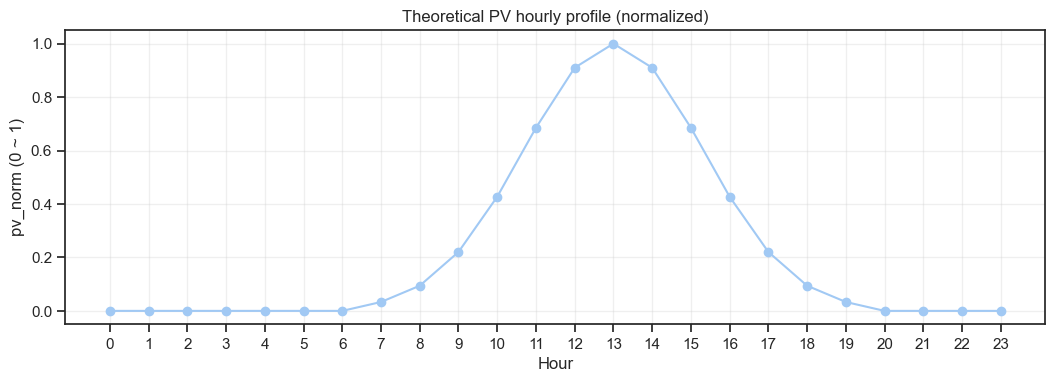

In [5]:
# 3. PV 이론 패턴 확인
plt.figure(figsize = (10, 3))
plt.plot(pv_profile_24h["hour"], pv_profile_24h["pv_norm"], marker = "o")
plt.xticks(range(0, 24))
plt.xlabel("Hour")
plt.ylabel("pv_norm (0 ~ 1)")
plt.title("Theoretical PV hourly profile (normalized)")
plt.grid(True, alpha = 0.3)
plt.show()

In [6]:
# 4. 시나리오 정의
# - pv_ratios: Load 대비 PV 비중 (10% ~ 40%)
# - PV(kW)는 load_peak × pv_ratio × pv_norm 으로 스케일링
# (시간대 분석용 형태 기반 접근)
pv_ratios = [0.10, 0.20, 0.30, 0.40] # 시나리오
pv_labels = [f"PV {int(r * 100)}%" for r in pv_ratios]
pv_ratios, pv_labels 

([0.1, 0.2, 0.3, 0.4], ['PV 10%', 'PV 20%', 'PV 30%', 'PV 40%'])

In [7]:
# 5. 시나리오별 Net Load 생성
def build_natload_scenario(load_profile_24h: pd.DataFrame,
                           pv_profile_24h: pd.DataFrame,
                           load_peak: float,
                           pv_ratio: float) -> pd.DataFrame:
    # 시나리오별 Net Load 데이터프레임 생성
    tmp = load_profile_24h.merge(pv_profile_24h, on = "hour", how = "left").copy()
    tmp["pv_ratio"] = pv_ratio
    tmp["pv_kW"] = tmp["pv_norm"] * load_peak * pv_ratio
    tmp["net_load"] = tmp["load_mean"] - tmp["pv_kW"]
    return tmp[["hour", "load_mean", "pv_norm", "pv_ratio", "pv_kW", "net_load"]].sort_values("hour")

scenario_frames = []
for r in pv_ratios:
    df_s = build_natload_scenario(load_profile_24h, pv_profile_24h, load_peak, r)
    scenario_frames.append(df_s)

scenario_df = pd.concat(scenario_frames, ignore_index = True)
scenario_df.head()

,hour,load_mean,pv_norm,pv_ratio,pv_kW,net_load
0,0,4828.966546,0.0,0.1,0.0,4828.966546
1,1,4436.061656,0.0,0.1,0.0,4436.061656
2,2,4301.931715,0.0,0.1,0.0,4301.931715
3,3,4069.172541,0.0,0.1,0.0,4069.172541
4,4,4467.956892,0.0,0.1,0.0,4467.956892


In [8]:
# 시나리오 데이터 저장
scenario_df.to_csv(OUT_DIR / "DAY5_scenario_netload.csv", index = False, encoding = "utf-8-sig")
print("saved:", OUT_DIR / "DAY5_scenario_netload.csv")

saved: e:\seoul_pv_load_analysis\outputs\DAY5_scenario_netload.csv


In [9]:
# 6. 핵심 지표 정의
# - Evening Peak (18 ~ 22시): 태양광 이후 저녁 시간대 최대 Net Load
# - Duck Depth: 저녁 피크 - (Net Load 최소)
# - Max Ramp Rate: 시간당 Net Load 증가량(diff)의 최대값 (운영 제어 부담 / 급변 대응 난이도)
EVENING_HOURS = list(range(18, 23)) # 18, 19, 20, 21, 22

def compute_metrics(df_one: pd.DataFrame) -> dict:
    # 단일 시나리오(24h) df에서 지표 계산
    df_one = df_one.sort_values("hour").copy()
    net = df_one["net_load"].astype(float).reset_index(drop = True)

    evening_peak = float(df_one.loc[df_one["hour"].isin(EVENING_HOURS), "net_load"].max())
    net_min = float(net.min())
    duck_depth = float(evening_peak - net_min)

    ramp = net.diff()
    max_ramp = float(ramp.max()) # 최대 증가량(상승 램프)
    min_ramp = float(ramp.min()) # 최대 감소량(하강 램프) - 참고용

    # 운영 관점 보조 지표(선택): 잉여 / 부족 총량
    # Net_load < 0: PV가 부하를 초과(잉여)
    surplus_total = float((-df_one["net_load"].clip(upper = 0)).sum())
    deficit_total = float((df_one["net_load"].clip(lower = 0)).sum())

    return {
        "pv_ratio": float(df_one["pv_ratio"].iloc[0]),
        "evening_peak": evening_peak,
        "net_min": net_min,
        "duck_depth": duck_depth,
        "max_ramp": max_ramp,
        "min_ramp": min_ramp,
        "surplus_total": surplus_total,
        "deficit_total": deficit_total
    }

metrics = []
for r in pv_ratios:
    df_one = scenario_df[scenario_df["pv_ratio"] == r]
    metrics.append(compute_metrics(df_one))

metrics_df = pd.DataFrame(metrics).sort_values("pv_ratio")
metrics_df["pv_label"] = metrics_df["pv_ratio"].map(lambda x: f"PV {int(x * 100)}%")
metrics_df

,pv_ratio,evening_peak,net_min,duck_depth,max_ramp,min_ramp,surplus_total,deficit_total,pv_label
0,0.1,6972.052472,4069.172541,2902.879931,852.042482,-514.092136,0.0,143606.488761,PV 10%
1,0.2,6900.058323,4069.172541,2830.885783,805.502700,-514.092136,0.0,139216.955504,PV 20%
2,0.3,6828.064175,4069.172541,2758.891634,758.962919,-514.092136,0.0,134827.422247,PV 30%
3,0.4,6756.070027,4069.172541,2686.897486,764.058044,-704.610292,0.0,130437.888991,PV 40%


In [10]:
# 7. 지표 저장
metrics_df.to_csv(OUT_DIR / "DAY5_metrics_summary.csv", index = False, encoding = "utf-8-sig")
print("Saved:", OUT_DIR / "DAY5_metrics_summary.csv")

Saved: e:\seoul_pv_load_analysis\outputs\DAY5_metrics_summary.csv


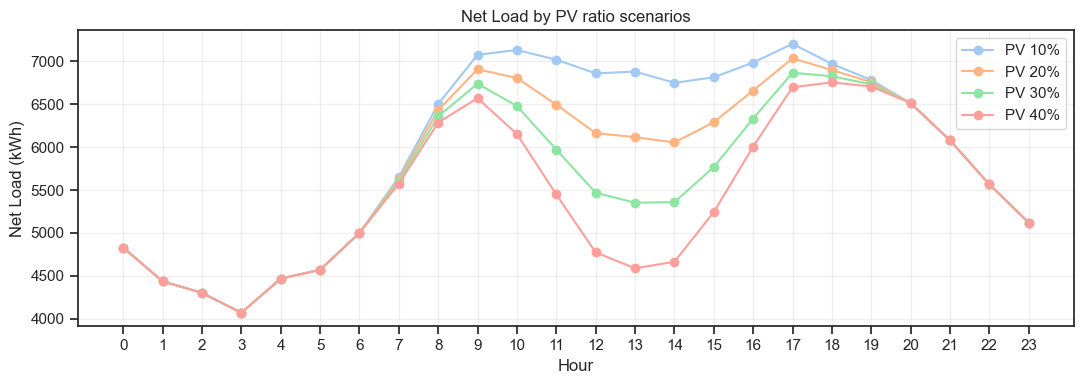

In [11]:
# 8. 시각화
# DAY 5는 비교 / 설명 가능한 구조가 목표
# - 시나리오별 Net Load 곡선 비교
# - PV 비중별 Evening Peak 변화
# - PV 비중별 Max Ramp Rate 변화

# 8-1) Net Load 곡선 비교
plt.figure(figsize = (11, 4))

for r in pv_ratios:
    tmp = scenario_df[scenario_df["pv_ratio"] == r].sort_values("hour")
    plt.plot(tmp["hour"], tmp["net_load"], marker = "o", label = f"PV {int(r * 100)}%")

plt.xticks(range(0, 24))
plt.xlabel("Hour")
plt.ylabel("Net Load (kWh)")
plt.title("Net Load by PV ratio scenarios")
plt.grid(True, alpha = 0.3)
plt.legend()
plt.tight_layout()
plt.show()

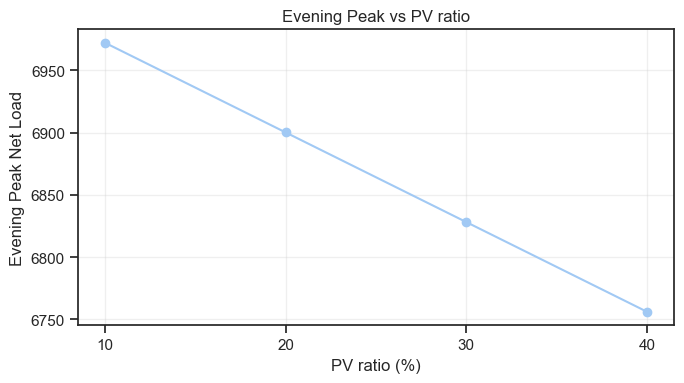

In [12]:
# 8-2) Evening Peak 변화
plt.figure(figsize = (7, 4))
plt.plot(metrics_df["pv_ratio"] * 100, metrics_df["evening_peak"], marker = "o")
plt.xticks(metrics_df["pv_ratio"] * 100)
plt.xlabel("PV ratio (%)")
plt.ylabel("Evening Peak Net Load")
plt.title("Evening Peak vs PV ratio")
plt.grid(True, alpha = 0.3)
plt.tight_layout()
plt.show()

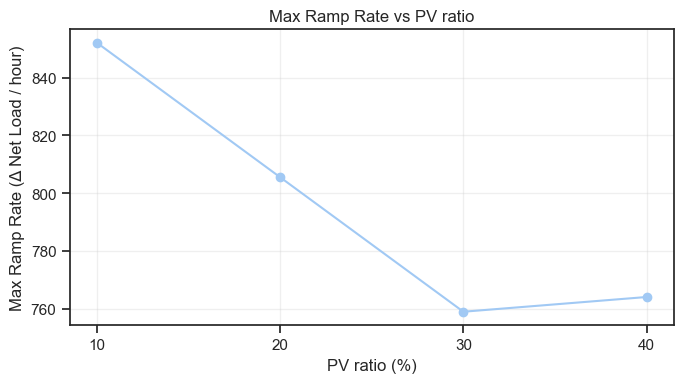

In [13]:
# 8-3) Max Ramp Rate 변화
plt.figure(figsize = (7, 4))
plt.plot(metrics_df["pv_ratio"] * 100, metrics_df["max_ramp"], marker = "o")
plt.xticks(metrics_df["pv_ratio"] * 100)
plt.xlabel("PV ratio (%)")
plt.ylabel("Max Ramp Rate (Δ Net Load / hour)")
plt.title("Max Ramp Rate vs PV ratio")
plt.grid(True, alpha = 0.3)
plt.tight_layout()
plt.show()

In [14]:
# 9. DAY 5 최종 해석 문장 자동 생성
# 보고서 / README에 그대로 붙일 수 있는 문장을 만들어 요약한다.
# (수치 자리는 자동으로 채워지며, PV 20% VS PV 40% 비교를 기본으로 함)

def generate_day5_narrative(metrics_df: pd.DataFrame, pv_base = 20, pv_high = 40) -> str:
    def _fmt(x):
        try:
            return f"{float(x):.1f}"
        except Exception:
            return str(x)
    
    base = metrics_df.loc[(metrics_df["pv_ratio"] * 100).astype(int) == pv_base].iloc[0]
    high = metrics_df.loc[(metrics_df["pv_ratio"] * 100).astype(int) == pv_high].iloc[0]

    lines = []
    lines.append("DAY 5 에서는 PV 비중 시나리오(10 ~ 40%)에 따라 Net Load를 생성하고, 덕 커브를 지표로 정량화했다.")
    lines.append(
        f"PV {pv_base}% 대비 PV {pv_high}% 에서 저녁 피크(Evening Peak)는 {_fmt(base['evening_peak'])} -> {_fmt(high['evening_peak'])}로 변화했다.")
    lines.append(
        f"덕 커브 깊이(Duck Depth)는 {_fmt(base['duck_depth'])} -> {_fmt(high['duck_depth'])}로 변화했으며, 이는 낮-저녁 간 시간대 불일치가 심화됨을 의미한다.")
    lines.append(
        f"최대 램프(Max Ramp Rate)는 {_fmt(base['max_ramp'])} -> {_fmt(high['max_ramp'])}로 변화해, 단시간 급변 대응(유연성 / 제어 부담)의 증가 가능성을 시사한다.")
    lines.append(
        "결론적으로 PV 최대는 총량 문제를 완화할 수 있으나, 운영 관점에서는 저녁 피크 및 급격한 부하 변화라는 시간대 리스크를 함께 확대할 수 있다.")
    return "\n".join([f"- {s}" for s in lines])

print("===DAY 5 최종 해석 문장===")
print(generate_day5_narrative(metrics_df, pv_base = 20, pv_high = 40))

===DAY 5 최종 해석 문장===
- DAY 5 에서는 PV 비중 시나리오(10 ~ 40%)에 따라 Net Load를 생성하고, 덕 커브를 지표로 정량화했다.
- PV 20% 대비 PV 40% 에서 저녁 피크(Evening Peak)는 6900.1 -> 6756.1로 변화했다.
- 덕 커브 깊이(Duck Depth)는 2830.9 -> 2686.9로 변화했으며, 이는 낮-저녁 간 시간대 불일치가 심화됨을 의미한다.
- 최대 램프(Max Ramp Rate)는 805.5 -> 764.1로 변화해, 단시간 급변 대응(유연성 / 제어 부담)의 증가 가능성을 시사한다.
- 결론적으로 PV 최대는 총량 문제를 완화할 수 있으나, 운영 관점에서는 저녁 피크 및 급격한 부하 변화라는 시간대 리스크를 함께 확대할 수 있다.


In [15]:
# 1) hour가 0~23로 잘 있는지
assert load_profile_24h["hour"].min() == 0 and load_profile_24h["hour"].max() == 23
assert load_profile_24h["hour"].nunique() == 24

# 2) PV 정규화 확인 (최대 1)
assert abs(pv_profile_24h["pv_norm"].max() - 1) < 1e-9

# 3) 시나리오별 데이터 24*4 = 96행인지
assert scenario_df.shape[0] == 24 * len(pv_ratios)

print("✅ Day5 sanity check PASSED")

✅ Day5 sanity check PASSED


In [ ]:
# 10. DAY 6 으로 넘기는 포인트
# DAY 6 에서는 DAY 5 지표를 바탕으로:
# - 위험 시간대(peak / ramp) 정의
# - ESS / DR 개입 타이밍(언제 충전, 언제 방전 / 감축)을 운영 시나리오로 연결
# - "설비 확대 VS 운영 전환" 비교 논리 정리

In [16]:
print(Path.cwd())

e:\seoul_pv_load_analysis\notebooks


In [20]:
OUT_DIR = Path.cwd().parent / "outputs"

print("Using outputs:", OUT_DIR)

rename_map = {
    "day2_hourly_load_profile.csv": "DAY2_hourly_load_profile.csv",
    "day3_pv_theoretical_profile.csv": "DAY3_pv_theoretical_profile.csv",
    "day4_net_load_base.csv": "DAY4_net_load_base.csv"
}

for old, new in rename_map.items():
    old_path = OUT_DIR / old
    tmp_path = OUT_DIR / f"__tmp__{old}"
    new_path = OUT_DIR / new

    if old_path.exists():
        # 1단계: 임시 이름으로 변경
        old_path.rename(tmp_path)
        # 2단계: 최종 이름으로 변경
        tmp_path.rename(new_path)
        print(f"✔ Renamed: {old} → {new}")
    else:
        print(f"✘ Not found: {old}")

Using outputs: e:\seoul_pv_load_analysis\outputs
✔ Renamed: day2_hourly_load_profile.csv → DAY2_hourly_load_profile.csv
✔ Renamed: day3_pv_theoretical_profile.csv → DAY3_pv_theoretical_profile.csv
✔ Renamed: day4_net_load_base.csv → DAY4_net_load_base.csv


In [21]:
sorted([f.name for f in (Path.cwd().parent / "outputs").glob("*.csv")])

['DAY2_hourly_load_profile.csv',
 'DAY3_pv_theoretical_profile.csv',
 'DAY4_net_load_base.csv',
 'DAY5_metrics_summary.csv',
 'DAY5_scenario_netload.csv']